In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from time import time

H=100, W=100


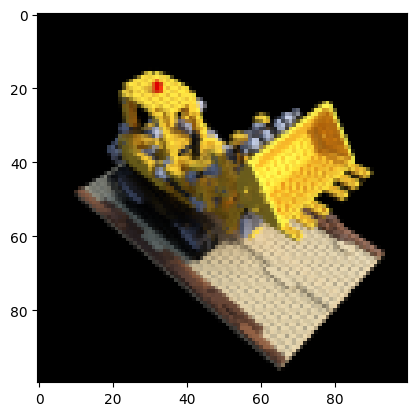

In [2]:
data = np.load("../data/tiny_nerf_data.npz")
imgs, poses, focal = data["images"], data["poses"], data["focal"]
_, H, W, _ = imgs.shape
test_img, test_pose = torch.tensor(imgs[101]), torch.tensor(poses[101])
imgs, poses = np.delete(imgs, 101, axis=0), np.delete(poses, 101, axis=0)

print(f"{H=}, {W=}")
plt.imshow(test_img)

In [3]:
def encode_pos(x, emb_dim):
    rets = [x]
    for i in range(emb_dim):
        rets.append(torch.sin(2.**i * x))
        rets.append(torch.cos(2.**i * x))
    return torch.cat(rets, dim=0)

def get_ray_origin_dir(H, W, focal, pose):
    i, j = torch.meshgrid(torch.arange(H), torch.arange(W), indexing="xy")
    dirs = torch.stack([
        +(i - H/2) / focal,
        -(j - W/2) / focal,
        -torch.ones_like(i)
    ], dim=-1)
    ray_dirs = (dirs @ pose[:3, :3].T).permute(2, 0, 1)
    ray_origin = pose[:3, -1].view(3, 1, 1)
    return ray_origin, ray_dirs

def get_rays(H, W, focal, pose, near, far, num_samples, emb_dim, rand):
    rayo, rayd = get_ray_origin_dir(H, W, focal, pose)
    depths = torch.linspace(near, far, num_samples).view(num_samples, 1, 1, 1)
    if rand:
        noise = torch.rand([num_samples, 1, H, W])
        depths = depths + noise
    rays = rayo + rayd * depths
    rays = rays.reshape(-1, H, W)
    return encode_pos(rays, emb_dim)

get_rays(H, W, focal, torch.tensor(poses[0]), 2, 6, 1, 0, "g").shape

torch.Size([3, 100, 100])

In [7]:
h, w, f = 4, 4, 2
near, far = 2, 6
num_samples = 2
emb_dim = 0
rand = True
pose = torch.tensor([
    [-9.9990219e-01,  4.1922452e-03, -1.3345719e-02, -5.3798322e-02],
    [-1.3988681e-02, -2.9965907e-01,  9.5394367e-01,  3.8454704e+00],
    [-4.6566129e-10,  9.5403719e-01,  2.9968831e-01,  1.2080823e+00],
    [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]
])

rayo, rayd = get_ray_origin_dir(h, w, f, pose)
print(rayd.shape)
depths = torch.linspace(near, far, num_samples).view(num_samples, 1, 1, 1)
if rand:
    noise = torch.rand([num_samples, 1, h, w])
    depths = depths + noise
print(depths.shape)
rays = rayo + (rayd * depths.view(-1, 1, 1, 1))
rays = rays.reshape(-1, h, w)
rays = encode_pos(rays, emb_dim)
print(rays)

torch.Size([3, 4, 4])
torch.Size([2, 1, 4, 4])
tensor([[[ 2.4641,  1.2269, -0.0104, -1.2477],
         [ 2.4589,  1.2217, -0.0156, -1.2528],
         [ 2.4537,  1.2165, -0.0208, -1.2580],
         [ 2.4486,  1.2113, -0.0260, -1.2632]],

        [[ 0.7777,  0.7604,  0.7431,  0.7258],
         [ 1.1485,  1.1312,  1.1139,  1.0966],
         [ 1.5193,  1.5020,  1.4847,  1.4674],
         [ 1.8901,  1.8728,  1.8555,  1.8382]],

        [[ 2.8274,  2.8274,  2.8274,  2.8274],
         [ 1.6469,  1.6469,  1.6469,  1.6469],
         [ 0.4664,  0.4664,  0.4664,  0.4664],
         [-0.7141, -0.7141, -0.7141, -0.7141]],

        ...,

        [[ 6.9915,  3.5296,  0.0676, -3.3943],
         [ 6.9770,  3.5151,  0.0531, -3.4088],
         [ 6.9625,  3.5006,  0.0386, -3.4233],
         [ 6.9480,  3.4861,  0.0241, -3.4378]],

        [[-4.7383, -4.7868, -4.8352, -4.8836],
         [-3.7008, -3.7493, -3.7977, -3.8461],
         [-2.6633, -2.7118, -2.7602, -2.8086],
         [-1.6258, -1.6742, -1.7227, -

In [8]:
class ResNetBlock(nn.Module):

    def __init__(self, channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
        self.act = nn.ReLU()

    def forward(self, x):
        skip = x
        x = self.act(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return x + skip

class SuperResBlock(nn.Sequential):

    def __init__(self, in_channels, out_channels, num_convs):
        layers = [
            #nn.Upsample(scale_factor=2),
            #nn.Conv2d(in_channels, out_channels, 1)
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        ]
        for _ in range(num_convs):
            layers.append(ResNetBlock(out_channels, 1))
        super().__init__(*layers)

class MobileR2L(nn.Sequential):

    def __init__(self, in_channels, hidden_channels, num_layers, num_sr_modules):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, 1), nn.ReLU()
        )
        self.body = nn.Sequential(*[
            ResNetBlock(hidden_channels, 1)
            for _ in range(num_layers)
        ])
        self.upscale = nn.Sequential(*[
            SuperResBlock(hidden_channels//(2**i), hidden_channels//(2**(i+1)), 2)
            for i in range(num_sr_modules)
        ])
        self.tail = nn.Conv2d(hidden_channels//(2**num_sr_modules), 3, 1)
    
    def forward(self, x):
        x = self.head(x)
        x = self.body(x) + x
        x = self.upscale(x)
        return self.tail(x)

with torch.no_grad():
    model = MobileR2L(21, 256, 8, 0).cuda()
    x = get_rays(H, W, focal, torch.tensor(poses[0]), 2, 6, 1, 3, rand=True).unsqueeze(0).cuda()
    #%timeit model(x)
    out = model(x)
    print(out.shape)
    print(sum(p.numel() for p in model.parameters()))
    #torch.save(model, "test_tr.pt")

torch.Size([1, 3, 100, 100])
1067267


  0%|                         | 11/10000 [00:02<34:10,  4.87it/s, loss=1.79e-01]


KeyboardInterrupt: 

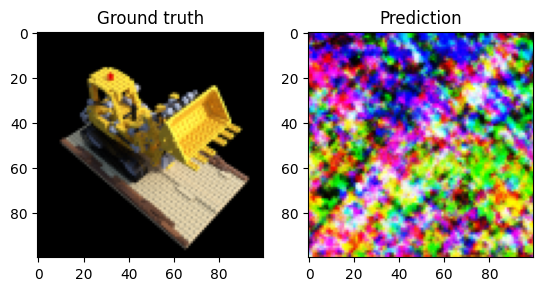

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
images_to_plot = 20

emb_dim = 6
num_samples = 16
num_iters = 10000
near, far = 2., 6.
rand = True
num_images, H, W, _ = imgs.shape

model = MobileR2L(3*(emb_dim*2+1)*num_samples, 256, 16, 0).to(device)
optim = torch.optim.Adam(model.parameters(), 1e-4)
criterion = F.mse_loss

history = []
for i in (pbar := tqdm(range(num_iters), ncols=80)):
    
    index = torch.randint(0, num_images, [1])[0]
    img = torch.tensor(imgs[index]).permute(2, 0, 1).to(device)
    pose = torch.tensor(poses[index])
    
    x = get_rays(
        H, W, focal, pose, near, far,
        num_samples, emb_dim, rand).unsqueeze(0).to(device)
    pred_img = F.sigmoid(model(x)).squeeze(0)
    loss = criterion(pred_img, img)

    history.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()
    pbar.set_postfix({"loss": f"{loss.item():.2e}"})

    if i % (num_iters // images_to_plot) == 0:
        with torch.no_grad():
            x = get_rays(
                H, W, focal, test_pose, near, far,
                num_samples, emb_dim, rand=False).unsqueeze(0).to(device)
            pred_img = F.sigmoid(model(x)).squeeze(0).permute(1, 2, 0)

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(test_img)
        ax[0].set_title("Ground truth")
        ax[1].imshow(pred_img.cpu())
        ax[1].set_title("Prediction")

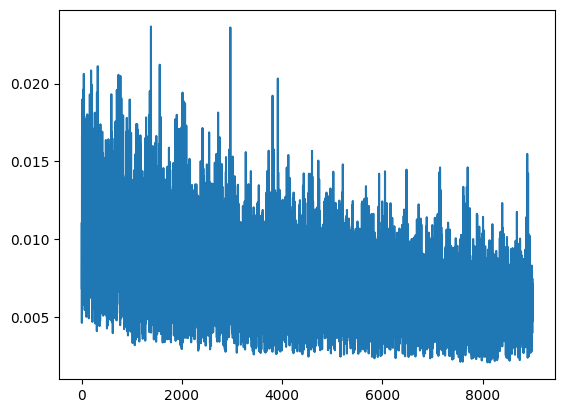

In [88]:
plt.plot(history[1000:])

Text(0.5, 1.0, 'Prediction')

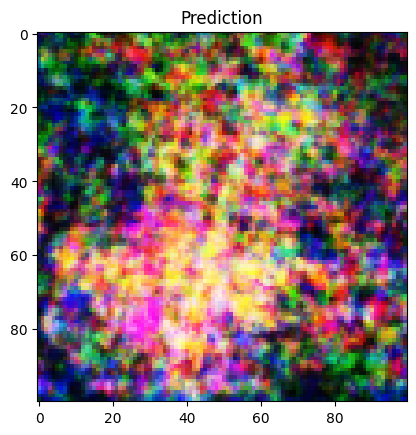

In [11]:
from math import sin, cos, radians

tr_r = lambda r : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,r],
    [0,0,0,1.],
])

rot_phi = lambda phi: torch.tensor([
    [1,0,0,0],
    [0,cos(phi),-sin(phi),0],
    [0,sin(phi), cos(phi),0],
    [0,0,0,1.],
])

rot_theta = lambda th : torch.tensor([
    [cos(th),0,-sin(th),0],
    [0,1,0,0],
    [sin(th),0, cos(th),0],
    [0,0,0,1.],
])

def get_pose_spherical(r, phi, theta):
    perm = torch.tensor([[-1.,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
    return perm @ rot_theta(radians(theta)) @ rot_phi(radians(phi)) @ tr_r(r)

pose = get_pose_spherical(4, -30, 150)

with torch.no_grad():
    x = get_rays(H, W, focal, pose, near, far, num_samples, emb_dim, rand=False).unsqueeze(0).to(device)
    pred_img = F.sigmoid(model(x)).squeeze(0).permute(1, 2, 0)
fig, ax = plt.subplots(1, 1)
ax.imshow(pred_img.cpu())
ax.set_title("Prediction")

In [79]:
import cv2
writer = cv2.VideoWriter(
    "output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, (100,100))

for th in tqdm(torch.linspace(0, 360, 1200)):
    pose = get_pose_spherical(4,-30, th)
    rays = get_rays(H, W, focal, pose, near, far, num_samples, emb_dim, False).to(device)
    with torch.no_grad():
        pred_img = F.sigmoid(model(rays.unsqueeze(0))).squeeze(0).permute(1, 2, 0)
    cv2img = cv2.cvtColor((pred_img * 255).cpu().to(torch.uint8).numpy(), cv2.COLOR_RGB2BGR)
    writer.write(cv2img)

writer.release()

  0%|          | 0/1200 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [97]:
#torch.save(model, "tiny_nelf.pt")

In [80]:
rays = torch.zeros(624, 50, 50, dtype=torch.float32)

In [98]:
model = MobileR2L(3*(emb_dim*2+1)*num_samples, 128, 60, 0)

In [99]:
import onnxruntime
out_path = "inference_csr/model.onnx"

#include your pytorch model creation or loading here
model = model.eval()
dummy_input = rays.unsqueeze(0)

#save to onnx
torch.onnx.export(model,               # model being run
                  dummy_input,                         # model input (or a tuple for multiple inputs)
                  out_path,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=17,          # the ONNX version to export the model to
                  do_constant_folding=False, # whether to execute constant folding for optimization
                  output_names=["out"], 
                  )

torch_out=model(dummy_input)
ort_session = onnxruntime.InferenceSession(out_path)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [100]:
ort_outs[0].shape

(1, 3, 50, 50)

In [101]:
ort_outs[0]

array([[[[-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         ...,
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784],
         [-0.32999784, -0.32999784, -0.32999784, ..., -0.32999784,
          -0.32999784, -0.32999784]],

        [[ 1.2432957 ,  1.2432957 ,  1.2432957 , ...,  1.2432957 ,
           1.2432957 ,  1.2432957 ],
         [ 1.2432957 ,  1.2432957 ,  1.2432957 , ...,  1.2432957 ,
           1.2432957 ,  1.2432957 ],
         [ 1.2432957 ,  1.2432957 ,  1.2432957 , ...,  1.2432957 ,
           1.2432957 ,  1.2432957 ],
         ...,
         [ 1.2432957 ,  1.2432957 

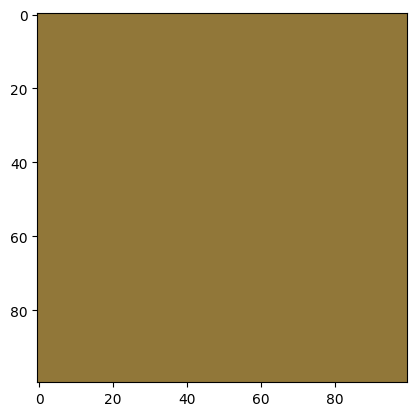

In [41]:
import onnxruntime
ort_session = onnxruntime.InferenceSession(out_path)
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)
plt.imshow(F.sigmoid(torch.tensor(ort_outs[0])).squeeze(0).permute(1, 2, 0))

In [42]:
ort_outs

[array([[[[ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          ...,
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ],
          [ 0.2874045 ,  0.2874045 ,  0.2874045 , ...,  0.2874045 ,
            0.2874045 ,  0.2874045 ]],
 
         [[-0.12756142, -0.12756142, -0.12756142, ..., -0.12756142,
           -0.12756142, -0.12756142],
          [-0.12756142, -0.12756142, -0.12756142, ..., -0.12756142,
           -0.12756142, -0.12756142],
          [-0.12756142, -0.12756142, -0.12756142, ..., -0.12756142,
           -0.12756142, -0.12756142],
          ...,
          [-0

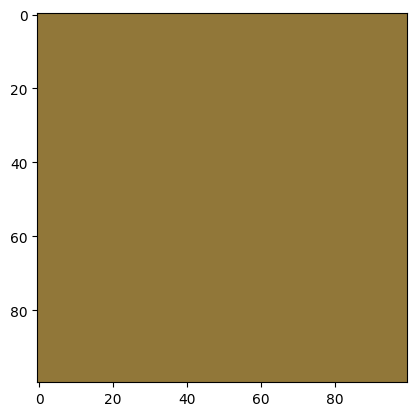

In [22]:
with torch.no_grad():
    torch_out = model(rays.unsqueeze(0))

plt.imshow(F.sigmoid(torch_out).squeeze(0).permute(1, 2, 0))